In [1]:

#Place in the postcodes and miles around them.
# If there is a 404 produced in the output you may have run to many searches in an hour or entered the postocde incorrctly so check the web string on the site
# For the radius in miles make sure you check the autotrader website for the allowed number of miles 
#https://www.autotrader.co.uk/

postcode_buy="MK3 6JS" 
radius_buy=20

postcode_sell="DT2 7LU" 
radius_sell=20

#Remeber to check the maximum and minimum years allowed on the website 
min_year=2010
max_year=2015 
min_price=0
max_price=10000

#State how many brands/ models you want to show in the final graphs 
no_brands = 50
no_models = 50

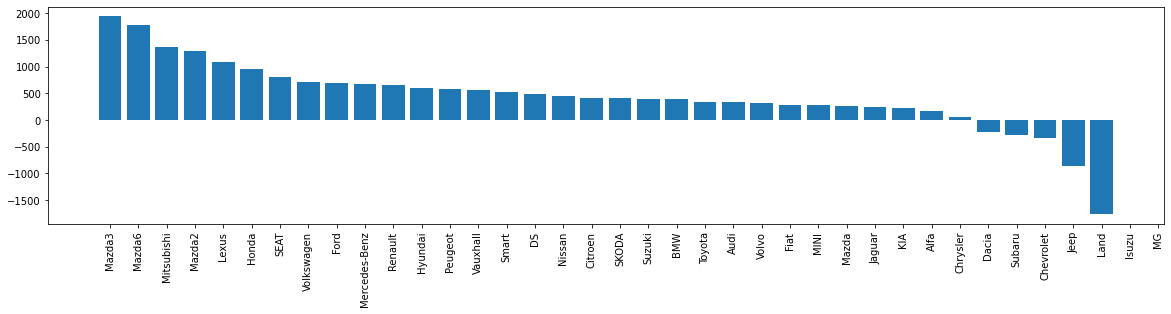

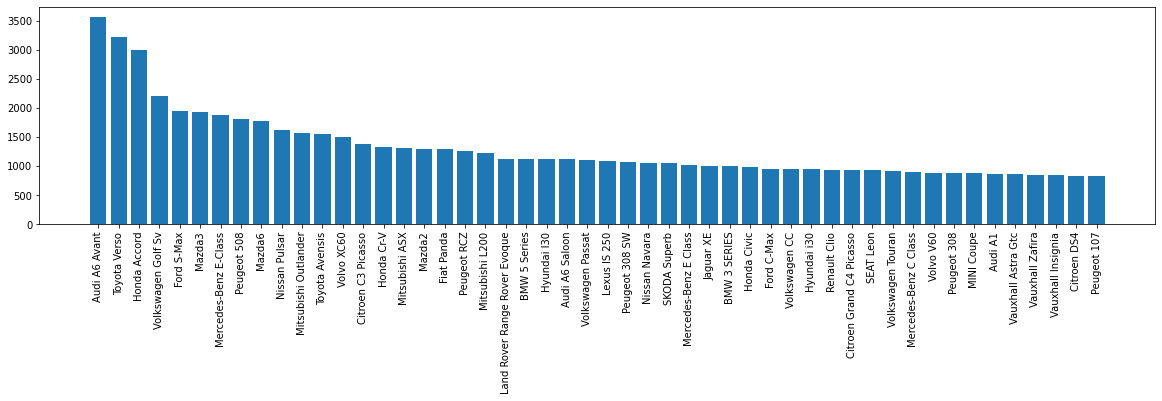

In [2]:
import requests
import json
import csv
from bs4 import BeautifulSoup
import modules.car_func as cf
import traceback
import cloudscraper
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
from re import sub
import matplotlib.pyplot as plt
from datetime import date
import os
import shutil
%matplotlib inline

location_buy = cf.retrieve_cars(
                           postcode = postcode_buy,
                           radius = radius_buy ,
                           min_year = min_year ,
                           max_year = max_year ,
                           min_price = min_price,
                           max_price = max_price,
                           location_type = 'buy')

location_sell = cf.retrieve_cars(
                           postcode = postcode_sell,
                           radius = radius_sell,
                           min_year = min_year ,
                           max_year = max_year ,
                           min_price = min_price,
                           max_price = max_price ,
                           location_type = 'sell')

location_buy.to_csv('location_tables\\location_buy.csv')
location_sell.to_csv('location_tables\\location_sell.csv')

location_buy = pd.read_csv('location_tables\\location_buy.csv').drop('Unnamed: 0',axis = 1)
location_sell = pd.read_csv('location_tables\\location_sell.csv').drop('Unnamed: 0',axis = 1)

car_match = location_buy.merge(location_sell, how = 'inner', left_on = cf.col_select(location_buy,['name','year']),
                       right_on = cf.col_select(location_sell,['name','year']))

car_match = cf.grouped_score(car_match,'index','buy_score')
car_match = cf.grouped_score(car_match,'name_buy','score_by_name')
car_match = cf.grouped_score(car_match,'brand_buy','score_by_brand')

#top 10 cars and urls
final_output = car_match.sort_values(by = 'buy_score' ,ascending= False)[['name_buy','price_buy','price_sell','postcode_buy','link_buy','postcode_sell','link_sell','mileage_buy','mileage_sell','engine_buy','engine_sell','buy_score','score_by_brand','score_by_name']]

#Create distinct file type name for each run 
today = date.today()
file_name = " ".join([today.strftime('%a') + today.strftime('%b') + str(today.strftime('%y')),postcode_buy,str(radius_buy),postcode_sell,str(radius_sell)]).replace(' ','_')

#Create a directory for the files to be stored in 
new_folder = "runs\\" + file_name

if os.path.exists(new_folder):
    shutil.rmtree(new_folder)

os.mkdir(new_folder)

final_output.to_csv(new_folder + "\\Total.csv" )

cf.graph_breakdown(car_match,'brand_buy','score_by_brand',no_brands,new_folder + "\\Total_brands.png")
cf.graph_breakdown(car_match,'name_buy','score_by_name',no_models,new_folder + "\\Total_models.png")


In [5]:
#Update the search term below to look for specific models and output to a csv 
#######################
search_term = 'citroen'
#######################
select_output = final_output[final_output['name_buy'].apply(lambda x: True if search_term.lower() in x.lower() else False )]

select_output.to_csv(new_folder + "\\" + search_term + ".csv" )

In [2]:
#No need to run just for testing purposes 
location_buy = pd.read_csv('location_buy.csv').drop('Unnamed: 0',axis = 1)
location_sell = pd.read_csv('location_sell.csv').drop('Unnamed: 0',axis = 1)

car_match = location_buy.merge(location_sell, how = 'inner', left_on = cf.col_select(location_buy,['name','year']),
                       right_on = cf.col_select(location_sell,['name','year']))

car_match = cf.grouped_score(car_match,'index','buy_score')
car_match = cf.grouped_score(car_match,'name_buy','score_by_name')
car_match = cf.grouped_score(car_match,'brand_buy','score_by_brand')